# Obsah prednasky

### myslienka a zmysel ucenia suborom metod

### bagging

#### hlasovanie

#### random forest

### boosting

### stacking

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

plt.rcParams['figure.figsize'] = 9, 6
from IPython.display import Image

# Zakladna myslienka

natrenovat viacero klasifikatrov (alebo inych algoritmov pre ine ulohy analyzy dat) a ich vysledky spojit

ked kombinujeme viacero nezavyslich a rozdielnych klasifikatorov, kde kazdy je aspon o trochu lepsi ako nahodne hadanie, tak nahodne chyby sa medzi sebou vyrusia a spravne predpovede sa posilnia

# Bias - variance

Ked trenujeme klasifikator, tak nasim cielom nie je naucit sa naspamat trenovacie data. Snazime sa naucit parametre procesy za datami, ktore tieto data generovali. 

toto je dolezite pre to, aby bol algoritmus dobre generalizovatelny tj. aby bol pouzitelny aj na datach, ktore nikdy nevidel a ktore boli generovane rovnakym procesom.

Musime sa vysporiadat s kompromisom medzi bias a variance


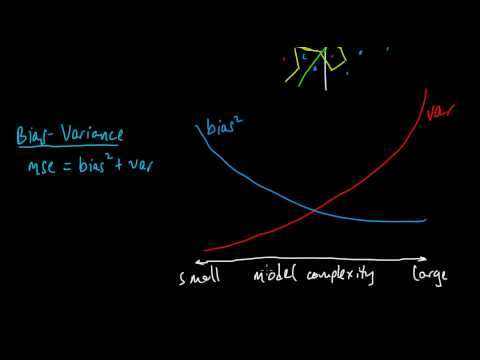

In [2]:
from IPython.display import YouTubeVideo

YouTubeVideo('W0NLs-A6hhQ')


# Bias (vychylenost)
model, ktory je prilis jednoduchy alebo neflexibilny bude mat prilis velky bias
bude mat velmi velku chybu na trenovacich aj testovacich datach. Tato chyba bude ale velmi stabilna. Ak mu dame data, ktore nikdy nevidel, tak bude fungovat priblizne rovnako dobre

# Variance (premenlivost)
zalezi od zlozitosti modelu

zlozity model sa velmi dobre nauci trenovacie data a bude mat na nich malu chybu. Akonahle mu ale dame data, ktore nevidel, tak ta chyba bude velmi premenliva a moze byt obrovska.

Obe tieto hodnoty potrebujeme znizit. Chceme presny klasifikator, ktory bude davat dobre vysledky aj na datach, ktore nikdy nevidel.

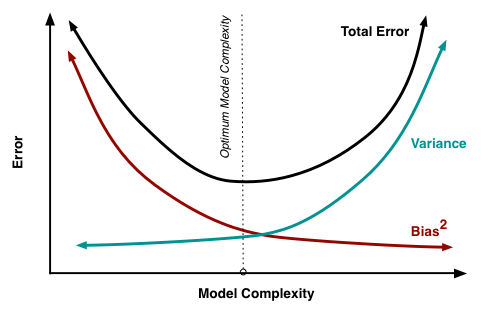

In [2]:
Image('./img/bias-variance.png', width='600px')

# Na redukovanie biasu a variance sa casto pouziva ensemble learning

**bagging** na redukovanie variancie

**boosting** na redukovanie biasu



# Bagging (Bootstrap aggregating)

Priemerovanie redukuje varianciu. Priemer predikcii je stabilnejsi ako jednotlive predikcie.

Pouzivame mnozstvo modelov. 

Otazka je: Ako ich natrenujeme na jednom datasete?

Kazdy je trenovany na nahodnom vybere (with replacement) z dat. 

Vysledna predikcia je tvorena priemerom predikcii jednotlivych modelov

Mozu sa pouzivat rovnake typy modelov. Dolezite ale je aby boli nekorelovane. Len nekorelovane modely sa totiz mozu doplnat. Ak by korelovali, tak sa budu navzajom podporovat a to len pokazi celu myslienku baggingu.

Rozne postupy na zabezpecenie nekorelovanosti modelov:
* rozne algoritmy na trenovanie modelov
* sampling
* feature bagging
* zmena reprezentacie atributov 
* zapojenie nahody (sum, nahodne parametre ...)
* ...


Najcastejsi priklad je random forest (tu sa ale pouziva feature bagging, pretoze ked sa pouziva bagging na riadkoch, tak casto vznikaju silno korelovane stromy)

# Metody kombinovania vysledkov modelov

* vahovanie
> uzitocne, ked jedlotlive modely maju porovnatelnu uspesnost

* meta-learning (vid stacking)
> uzitocne ak niektore modely konzistentne spravne predikuju niektore instancie

# Rozne sposoby vahovania

* **majority voting** - pri klasifikacii je trieda predikovanej instancie ta, ktoru oznacila vacsina modelov
* **performance weighting** - vaha kazdeho modelu je pri hlasovani urcena jeho uspesnostou
* **heuristic weighted voting** - optimalizacna metoda pouzita na natrenovanie vah (pozor na pretrenovanie)
* **Bayesovska kombinacia** - vaha je pravdepodobnsot, ze data splnaju nejaku hypotezu (model/nastavenie modelu). Skusaju sa rozne nastavenia parametrov

# Priklad vahovanie

pouzijeme rozne algoitmy na zabezpecenie toho, ze kombinovane modely su na sebe nezavysle

http://sebastianraschka.com/Articles/2014_ensemble_classifier.html

In [3]:
from sklearn import datasets

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

In [4]:
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
import numpy as np

np.random.seed(123)

clf1 = LogisticRegression()
clf2 = RandomForestClassifier()
clf3 = GaussianNB()

print('5-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3], ['Logistic Regression', 'Random Forest', 'naive Bayes']):

    scores = cross_validation.cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


5-fold cross validation:

Accuracy: 0.90 (+/- 0.05) [Logistic Regression]
Accuracy: 0.92 (+/- 0.05) [Random Forest]
Accuracy: 0.91 (+/- 0.04) [naive Bayes]


In [5]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
import numpy as np
import operator

class EnsembleClassifier(BaseEstimator, ClassifierMixin):
    """ 
    Ensemble classifier for scikit-learn estimators.
        
    Parameters
    ----------
    
    clf : `iterable`
      A list of scikit-learn classifier objects.
    weights : `list` (default: `None`)
      If `None`, the majority rule voting will be applied to the predicted class labels.
        If a list of weights (`float` or `int`) is provided, the averaged raw probabilities (via `predict_proba`)
        will be used to determine the most confident class label.
      
    """
    def __init__(self, clfs, weights=None):
        self.clfs = clfs
        self.weights = weights

    def fit(self, X, y):
        """ 
        Fit the scikit-learn estimators.
        
        Parameters
        ----------

        X : numpy array, shape = [n_samples, n_features]
            Training data
        y : list or numpy array, shape = [n_samples]
            Class labels
      
        """
        for clf in self.clfs:
            clf.fit(X, y)
            
    def predict(self, X):
        """
        Parameters
        ----------

        X : numpy array, shape = [n_samples, n_features]
        
        Returns
        ----------
        
        maj : list or numpy array, shape = [n_samples]
            Predicted class labels by majority rule
        
        """
        
        self.classes_ = np.asarray([clf.predict(X) for clf in self.clfs])
        if self.weights:
            avg = self.predict_proba(X)

            maj = np.apply_along_axis(lambda x: max(enumerate(x), key=operator.itemgetter(1))[0], axis=1, arr=avg)
        
        else:
            maj = np.asarray([np.argmax(np.bincount(self.classes_[:,c])) for c in range(self.classes_.shape[1])])
        
        return maj
            
    def predict_proba(self, X):
        
        """
        Parameters
        ----------

        X : numpy array, shape = [n_samples, n_features]
        
        Returns
        ----------
        
        avg : list or numpy array, shape = [n_samples, n_probabilities]
            Weighted average probability for each class per sample.
        
        """
        self.probas_ = [clf.predict_proba(X) for clf in self.clfs]
        avg = np.average(self.probas_, axis=0, weights=self.weights)
        
        return avg

In [6]:
np.random.seed(123)
eclf = EnsembleClassifier(clfs=[clf1, clf2, clf3], weights=[1,1,1])

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):

    scores = cross_validation.cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.5f (+/- %0.5f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.90000 (+/- 0.04714) [Logistic Regression]
Accuracy: 0.92000 (+/- 0.05416) [Random Forest]
Accuracy: 0.91333 (+/- 0.04000) [naive Bayes]
Accuracy: 0.95333 (+/- 0.03399) [Ensemble]


#### Mozeme skusit ovahovat klasifikatory ich uspesnostou

In [7]:
weights = []
for clf, label in zip([clf1, clf2, clf3], ['Logistic Regression', 'Random Forest', 'naive Bayes']):

    scores = cross_validation.cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    weights.append(scores.mean())

In [8]:
weights

[0.9, 0.9466666666666667, 0.9133333333333334]

In [9]:
np.random.seed(123)
eclf = EnsembleClassifier(clfs=[clf1, clf2, clf3], weights=weights)

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):

    scores = cross_validation.cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.5f (+/- %0.5f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.90000 (+/- 0.04714) [Logistic Regression]
Accuracy: 0.92000 (+/- 0.05416) [Random Forest]
Accuracy: 0.91333 (+/- 0.04000) [naive Bayes]
Accuracy: 0.95333 (+/- 0.03399) [Ensemble]


#### Mozeme tiez skusit implementaciu vahovacieho ensemblu priamo z sklearn

In [10]:
np.random.seed(10)

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import VotingClassifier

# Training classifiers
clf1 = LogisticRegression()
clf2 = RandomForestClassifier()
clf3 = GaussianNB()
eclf = VotingClassifier(estimators=[('LR', clf1), ('RF', clf2), ('NB', clf3)], voting='hard', weights=[1,1,1])

scores = cross_validation.cross_val_score(eclf, X, y, cv=5, scoring='accuracy')
scores.mean()

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

0.9533333333333334

#### Mozeme pouzit grid search na najdenie parametrov

In [11]:
from sklearn.model_selection import GridSearchCV
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')

params = {'lr__C': [1.0, 100.0], 'rf__n_estimators': [20, 200], 
          'weights': [[1,1,1], [0,1,1], [10,1,1]]}

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
grid = grid.fit(iris.data, iris.target)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

In [12]:
grid.grid_scores_

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.95333, std: 0.02667, params: {'lr__C': 1.0, 'rf__n_estimators': 20, 'weights': [1, 1, 1]},
 mean: 0.95333, std: 0.02667, params: {'lr__C': 1.0, 'rf__n_estimators': 20, 'weights': [0, 1, 1]},
 mean: 0.96000, std: 0.03887, params: {'lr__C': 1.0, 'rf__n_estimators': 20, 'weights': [10, 1, 1]},
 mean: 0.96000, std: 0.02494, params: {'lr__C': 1.0, 'rf__n_estimators': 200, 'weights': [1, 1, 1]},
 mean: 0.94667, std: 0.03399, params: {'lr__C': 1.0, 'rf__n_estimators': 200, 'weights': [0, 1, 1]},
 mean: 0.96000, std: 0.03887, params: {'lr__C': 1.0, 'rf__n_estimators': 200, 'weights': [10, 1, 1]},
 mean: 0.96000, std: 0.02494, params: {'lr__C': 100.0, 'rf__n_estimators': 20, 'weights': [1, 1, 1]},
 mean: 0.95333, std: 0.02667, params: {'lr__C': 100.0, 'rf__n_estimators': 20, 'weights': [0, 1, 1]},
 mean: 0.96000, std: 0.02494, params: {'lr__C': 100.0, 'rf__n_estimators': 20, 'weights': [10, 1, 1]},
 mean: 0.95333, std: 0.03399, params: {'lr__C': 100.0, 'rf__n_estimators': 200, 'weights

In [13]:
grid.cv_results_ 

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:1

{'mean_fit_time': array([0.04280491, 0.04629812, 0.04603982, 0.38044124, 0.38184361,
        0.38993387, 0.04461641, 0.04504476, 0.04368367, 0.4189795 ,
        0.39406061, 0.39754572]),
 'mean_score_time': array([0.00472302, 0.00476165, 0.00473976, 0.02822886, 0.02916722,
        0.03030825, 0.00581751, 0.00489535, 0.00469041, 0.03423915,
        0.02871385, 0.03152375]),
 'mean_test_score': array([0.95333333, 0.95333333, 0.96      , 0.96      , 0.94666667,
        0.96      , 0.96      , 0.95333333, 0.96      , 0.95333333,
        0.94666667, 0.96      ]),
 'mean_train_score': array([0.97      , 0.97166667, 0.975     , 0.97166667, 0.97166667,
        0.975     , 0.97166667, 0.97166667, 0.975     , 0.97      ,
        0.97166667, 0.97333333]),
 'param_lr__C': masked_array(data=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 100.0, 100.0, 100.0,
                    100.0, 100.0, 100.0],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, 

# á propos grid search

parametre sa daju nastavovat aj nahodne ak je ich priestor prilis velky

```
params_dist_grid = { 
    'max_depth': [1, 2, 3, 4],
    'gamma': [0, 0.5, 1],
    'n_estimators': randint(1, 1001), # uniform discrete random distribution
    'learning_rate': uniform(), # gaussian distribution
    'subsample': uniform(), # gaussian distribution
    'colsample_bytree': uniform() # gaussian distribution
}
```

```
rs_grid = RandomizedSearchCV(
    estimator=RandomForest(**params_fixed, seed=seed),
    param_distributions=params_dist_grid,
    n_iter=10, # dolezite je nastavit pocet iteracii
    cv=cv,
    scoring='accuracy',
    random_state=seed
)
rs_grid.fit(X, y)

```




## GridSearch alternativy

[https://sigopt.com/no-grid-search](https://sigopt.com/no-grid-search)

# Priklad Bagging

Pouzijeme ten isty algoritmus

Pouzijeme sampling na to, aby sme zabezpecili, ze budu modely na sebe nezavysle

priklad z: https://github.com/rasbt/python-machine-learning-book

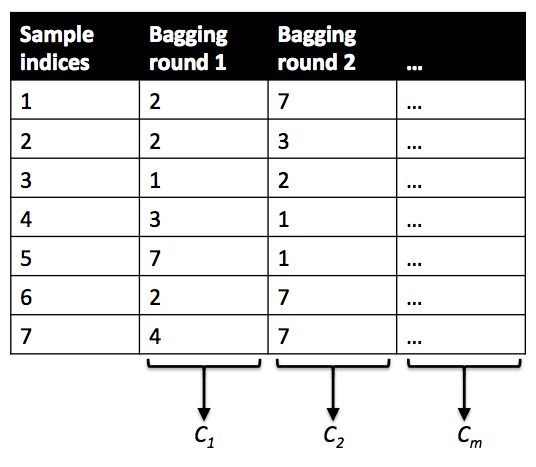

In [14]:
Image(filename='./img/bagging.png', width=400) 

In [15]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None, # nastavime hlbku na maximum, takze mu nijak nebudeme branit v pretrenovani
                              random_state=1)

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, # toto je rozdiel oproti random forest
                        n_jobs=1, 
                        random_state=1)

In [16]:
scores = cross_validation.cross_val_score(bag, X, y, cv=5, scoring='accuracy')
scores.mean()

0.9466666666666667

# ked si natrenujeme len jeden model, tak uspesnost asi bude mensia

In [17]:
scores = cross_validation.cross_val_score(tree, X, y, cv=5, scoring='accuracy')
scores.mean()

0.9066666666666666

Tato nizsia uspesnost je pravdepodobne sposobena tym, ze sa model pretrenoval. Baging mal dobru uspesnost, lebo pretrenovanie zmiernuje.

# co sa stane ak budem stromu aspon trochu brannit v pretrenovani

In [18]:
tree2 = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=2, # nenecham ho naucit sa tie data uplne naspamat
                              random_state=1)
scores = cross_validation.cross_val_score(tree2, X, y, cv=5, scoring='accuracy')
scores.mean()

0.9466666666666667

baggingom teda viem bojovat s pretrenovanim, teda s varianciou modelu

# Priklad Random forest

tento algoritmus som uz spominal vela krat, takze to nebudem natahovat

na rozdiel od klasickeho baggingu sa pouziva feature bagging

kedze nie kazda vlastnost je pouzita na kazdy strom, tak sa da pozriet, ktore najviac prispievaju k presnosti klasifikacie (regresie)

To sa da pouzit na vyber najuzitocnejsich atributov (ukazoval som minule)

Dost casto sa to pouziva v spojeni so spracovanim obrazkov na zobrazenie ktore casti obrazku su najdolezitejsie.

Pozor!!! aby ste toto mohli spravit, tak musite mat velmi kvalitne predpriprveny dataset. Vo vseobecnosti je lepsie nepozerat na konkretne pixely ale na vlastnosti vybrate z obrazku napriklad pomocou metody SIFT alebo Hough transformacie.

Ak mate totiz nejake posunutie, rotaciu alebo inak transformovany obrazok, tak konkretne pixely vam toho vela nepovedia


In [19]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.ensemble import ExtraTreesClassifier

# Number of cores to use to perform parallel fitting of the forest model
n_jobs = 1

# Load the faces dataset
data = fetch_olivetti_faces()
X = data.images.reshape((len(data.images), -1))
y = data.target

mask = y < 5  # Limit to 5 classes
X = X[mask]
y = y[mask]

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


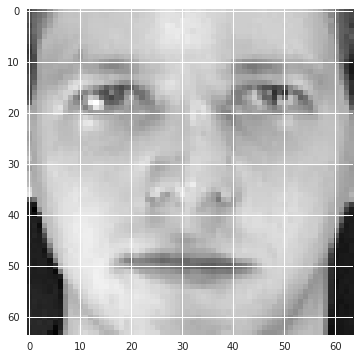

In [20]:
plt.imshow(data.images[0], cmap=plt.cm.gray)

Tu mam dataset, kde su obrazky pekne centrovane, rovnakej velkosti a bez nejakej deformacie

Cize dolezite pixely by mohli byt na rovnakom mieste

Fitting ExtraTreesClassifier on faces data with 1 cores...
CPU times: user 2.7 s, sys: 136 ms, total: 2.84 s
Wall time: 2.85 s


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


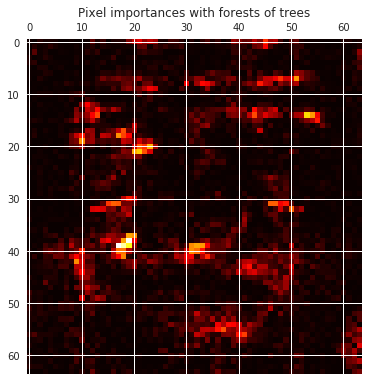

In [21]:
%%time

# Build a forest and compute the pixel importances
print("Fitting ExtraTreesClassifier on faces data with %d cores..." % n_jobs)

forest = ExtraTreesClassifier(n_estimators=1000,
                              max_features=128,
                              n_jobs=n_jobs,
                              random_state=0)

forest.fit(X, y)

importances = forest.feature_importances_
importances = importances.reshape(data.images[0].shape)

# Plot pixel importances
plt.matshow(importances, cmap=plt.cm.hot)
plt.title("Pixel importances with forests of trees")


# Boosting

Inkrementalne vyrabame nove klasifiktory, ktore dostavaju tie pozorovania, ktore boli predtym zle klasifikovane s vacsou vahou.

Typicky priklad AdaBoost (pekne vysvetlenie aj so vzorcami na vypocet vah http://machinelearningmastery.com/boosting-and-adaboost-for-machine-learning/)

## typicky postup

1. nastav vahu kazdemu trenovaciemu pripadu rovnomerne
2. natrenuj model slabim klasifikatorom
3. vypocitaj chybu natrenovaneho modelu na trenovacom datasete (tato chyba sa pouzije na vahovanie celeho modelu)
4. zmen vahy trenovacm pripadom. Zvys vahu tomu, ktory bol zle klasifikovany (ak algoritmus nevie pouzivat vahy, tak pouzi resampling)
5. skoc na krok 2 az dokedy nespravis maximalny pocet iteracii
* vysledy model su vahovane predikcie ciastkovych modelov (vaha z kroku 3)


Bagging ma problemy so sumom a outliermi. Snazi sa totiz spravne klasifikovat vsetko. Riziko pretrenovania

tazsie sa paralelizuje ako bagging

da sa pouzit early stop pri prdikcii ak si je niektory model v postupnosti dostatocne isty svojou predikciou

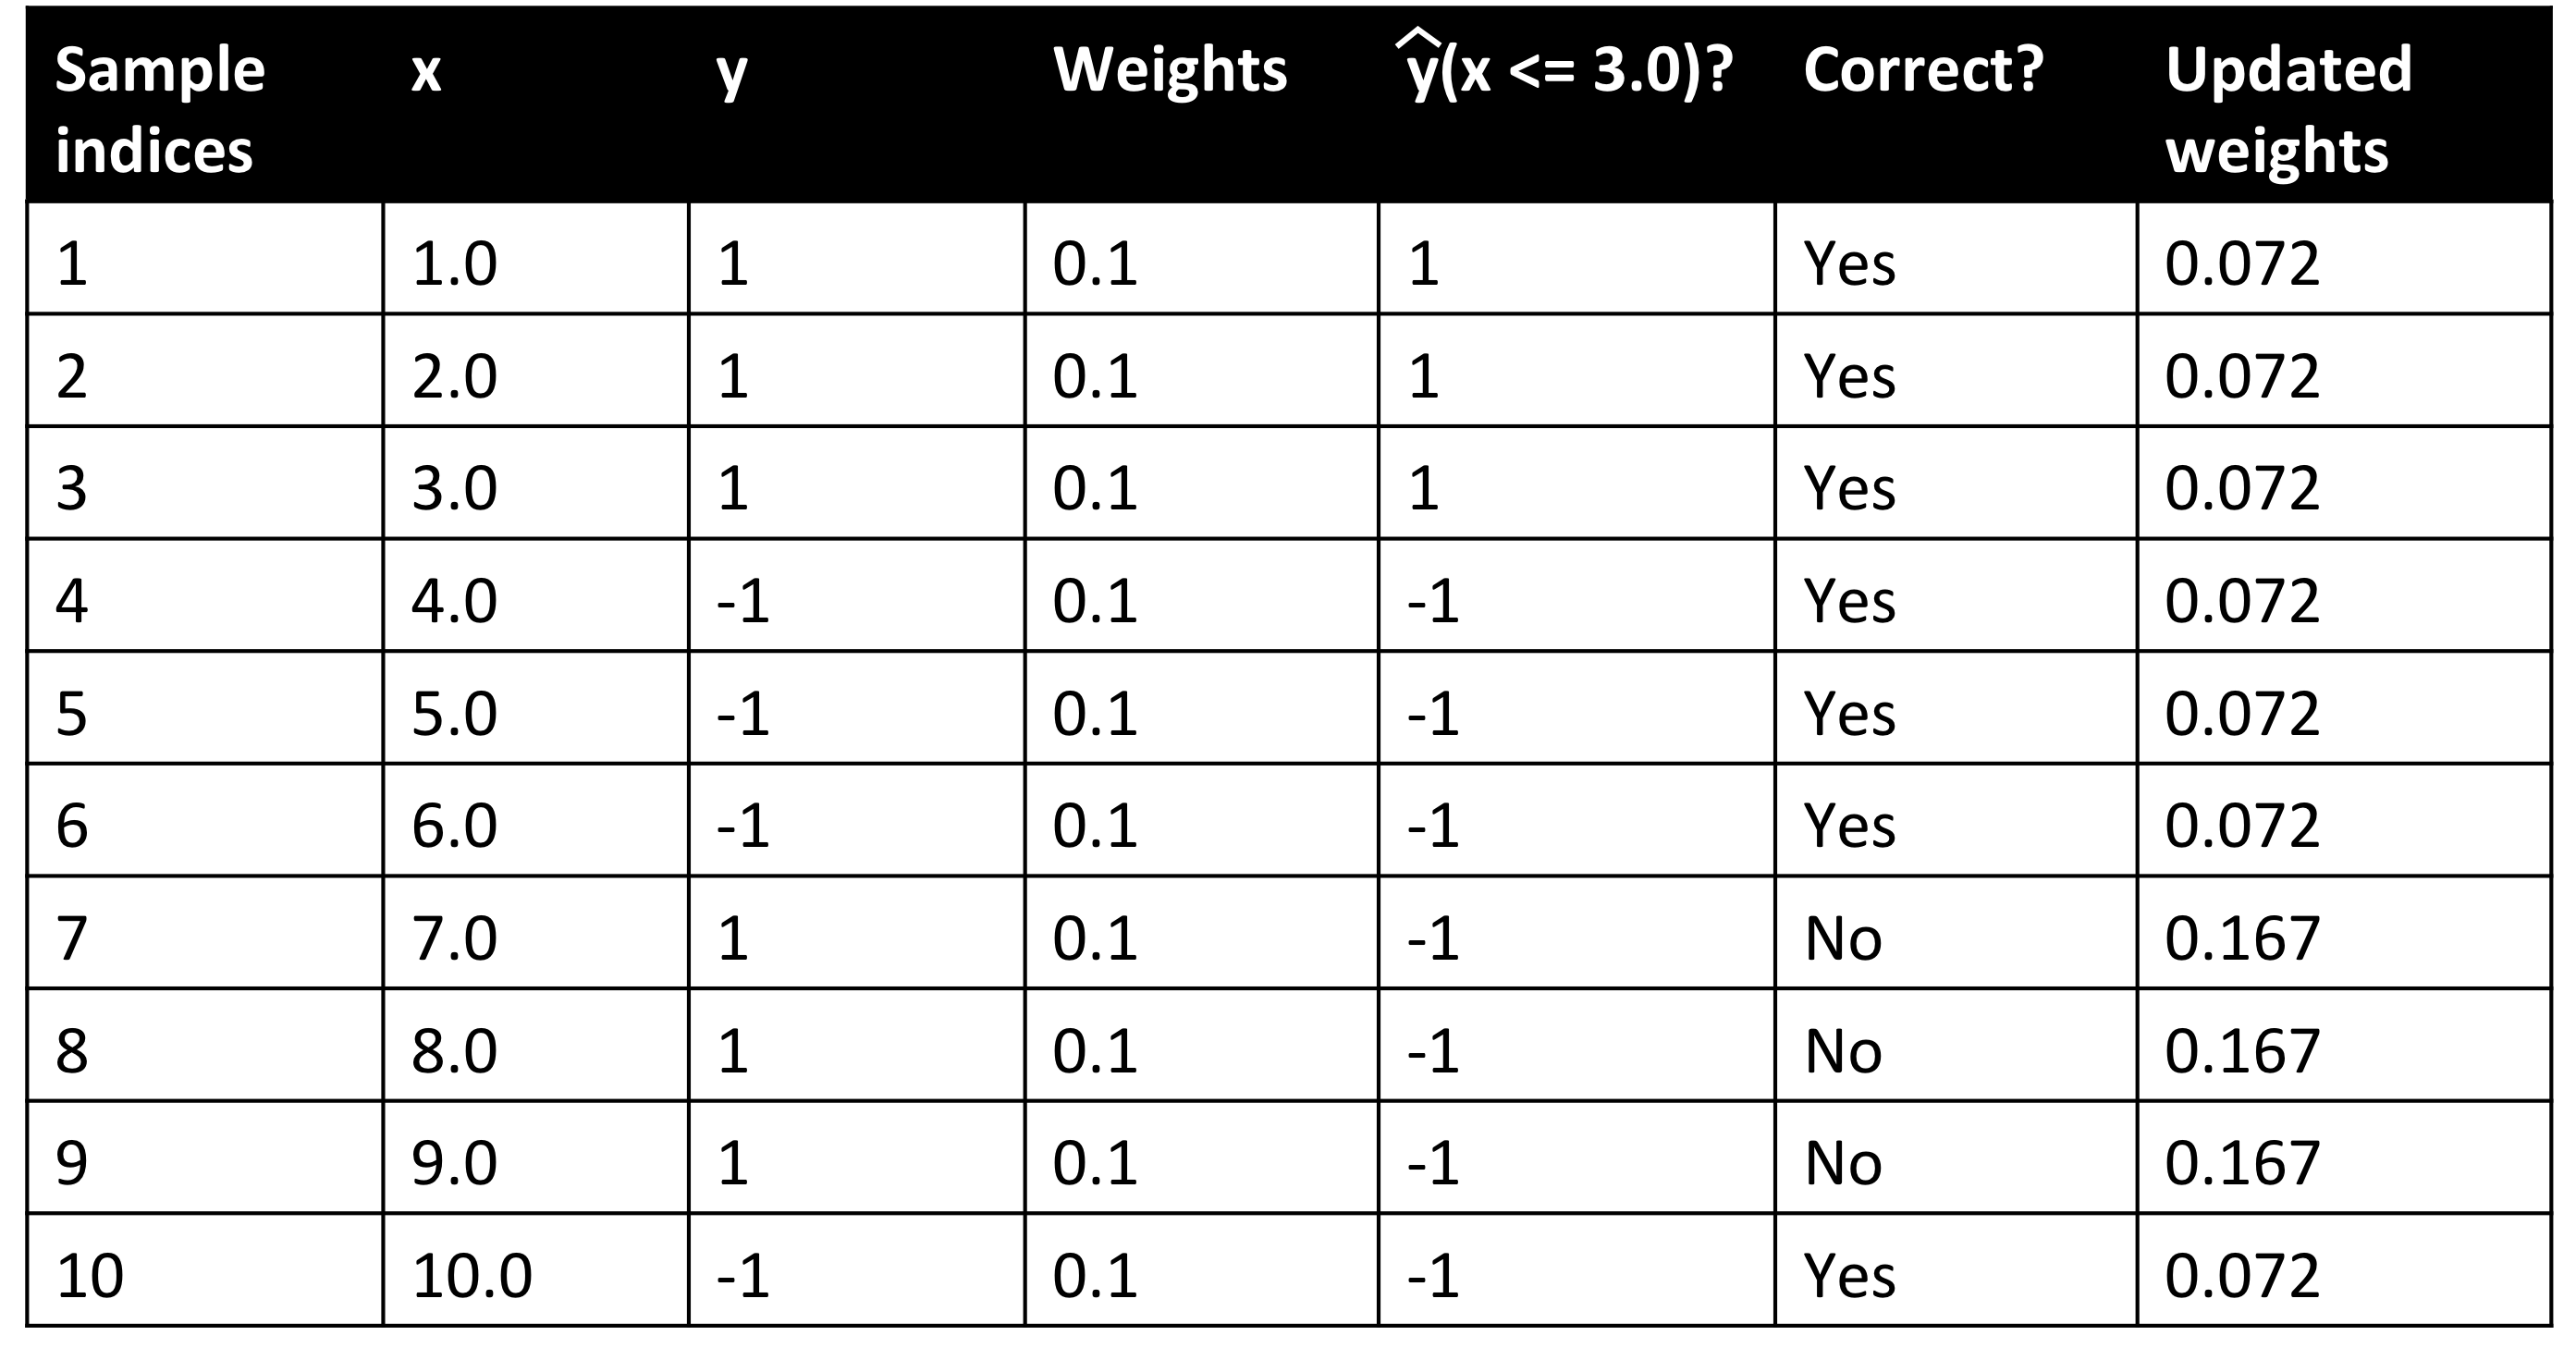

In [22]:
Image(filename='./img/boosting.png', width=600) 

In [23]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

# drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Hue']].values

In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


le = LabelEncoder() # toto mi opravi poradie tried. Ak som tam mal predtym napriklad -1, 7, 10 ..., tak potom budem mat 0,1,2 ...
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                             test_size=0.40, 
                             random_state=1)

In [29]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1, # nastavim hlbku na 1 aby sa trenovalo prave jedno pravidlo
                              random_state=0)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=100, 
                         learning_rate=0.1,
                         random_state=0)

In [30]:
# teraz naschval nebudem pouzivat cross validaciu, aby sme sa mohli pozriet ako sa modelu dari na testovacej aj trenovacej vzorke
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('AdaBoost train/test accuracies %.3f/%.3f'
      % (ada_train, ada_test))

Decision tree train/test accuracies 0.845/0.854
AdaBoost train/test accuracies 1.000/0.854


to, ze je uspesnost adaboost 100% na trenovacej sade moze zavanat pretrenovanim

to, ze je chybovost na testovacej taka velka to potvrdzuje

### skusme si nakreslit ako sa v skutocnosti ten priestor rozdeluje

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


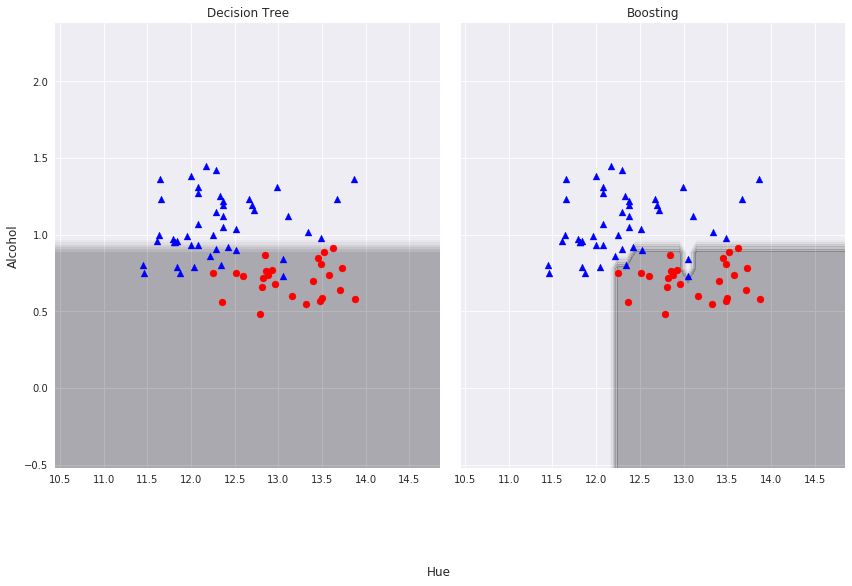

In [31]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(12, 7))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision Tree', 'Boosting']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='red', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2,
         s='Hue',
         ha='center', va='center', fontsize=12)

plt.tight_layout()

# naozaj ak je velky pocet modelov, tak sa to velmi rychlo pretrenuje

skusme sa pohrat s tym, kolko modelov sa pouziva na boosting alebo s learning rate

Inak je ale tato metoda velmi uzitocna ak mame naprikald nevyvazene triedy alebo je v datach viacero roznych pravidiel, na zaklade ktorych sa rozdeluju data

# Stacking

vsetky data su pouzite na natrenovanie roznych modelov

Vysledky modelov su pridane k datam a pouzite na natrenovanie dalsej urovne modelov.

Na kominovanie sa najcastejsie pouziva logisticka regresia.

Sklearn nema implementaciu stackingu. Skusme si ale naimplementovat primitivny stacking sami.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=1) # X a y stale obsahuje dataset vin

In [40]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression 

base_algorithms = [('svm', SVC(probability=True)),
           ('RF', RandomForestClassifier(n_estimators=100)), 
           ('ET', ExtraTreesClassifier(n_estimators=100))]

# stacking_train_dataset = pd.DataFrame()
# stacking_test_dataset = pd.DataFrame()

stacking_train_dataset = pd.DataFrame(X_train) # mozu sa pouzit povodne data ako zaklad a knim sa pridaju predikcie
stacking_test_dataset = pd.DataFrame(X_test)

for name, algorithm in base_algorithms: # mozu sa tu pridat aj pravdepodobnosti. Tiem odely to ale musia podporovat
    stacking_train_dataset[name] = algorithm.fit(X_train, y_train).predict(X_train)
#     stacking_train_dataset[name+"_proba"] = algorithm.fit(X_train, y_train).predict_proba(X_train)
    stacking_test_dataset[name] = algorithm.predict(X_test)
#     stacking_test_dataset[name+"_proba"] = algorithm.predict_proba(X_test)

In [41]:
stacking_train_dataset.head()

,0,1,svm,RF,ET
0,12.29,1.42,0,0,0
1,12.08,0.93,0,0,0
2,11.87,0.75,0,0,0
3,13.50,0.59,1,1,1
4,12.08,1.31,0,0,0


In [43]:
combiner_algorithm = LogisticRegression(max_iter=500)
final_predictions = combiner_algorithm.fit(stacking_train_dataset, y_train).predict(stacking_test_dataset)

In [44]:
accuracy_score(y_test, final_predictions) 

0.9375

In [45]:
accuracy_score(y_test, stacking_test_dataset.ET) 

0.91666666666666663

kasdy z jednotlivych klasifikatorov ma horsiu uspesnost ako ich spojenie

# Sklearn nema priamo implementaciu pre stacking, ale balicek Brew ano

In [46]:
import brew
from brew.base import Ensemble
from brew.combination.combiner import Combiner
from brew.stacking.stacker import EnsembleStack
from brew.stacking.stacker import EnsembleStackClassifier

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression 
 
layer_1 = [SVC(probability=True),
           RandomForestClassifier(n_estimators=100), 
           ExtraTreesClassifier(n_estimators=100)]
 
layer_2 = [SVC(probability=True), LogisticRegression(max_iter=500)]
 
stack = EnsembleStack(cv=10) # number of folds per layer
stack.add_layer(Ensemble(layer_1))
stack.add_layer(Ensemble(layer_2))
 
clf = EnsembleStackClassifier(stack, Combiner('mean'))

scores = cross_validation.cross_val_score(tree2, X, y, cv=5, scoring='accuracy')
scores.mean()

0.78265217391304343

tuna som pouzil malicky dataset vin a strasne vela klasifikatorov

pridal som do datasetu vela novych atributov a teda som sposobil, ze model ma celkom seriozny problem sa z toho mnozstva atributov nieco naucit. Uzitocnejsie by to bolo pouzit na nejaky vacsi dataset.

# Dalsie citanie

http://mlwave.com/kaggle-ensembling-guide/

# Pipelining

Uz len posledna vec na zaver.

Tu je velmi pekny tutorial, takze budem prezentovat priamo z neho

Nijak to ale neznizuje dolezitost tejto temy. Prave naopak, toto je velmi uzitocne.

http://machinelearningmastery.com/automate-machine-learning-workflows-pipelines-python-scikit-learn/

http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html

http://scikit-learn.org/stable/modules/pipeline.html

# Nevyvazene data

[Imbalanced learn](https://imbalanced-learn.readthedocs.io/en/stable/)

[priklad roznych metod](https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/over-sampling/plot_comparison_over_sampling.html#sphx-glr-auto-examples-over-sampling-plot-comparison-over-sampling-py)